In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
# 월별 통합 데이터 = df
df = pd.read_csv('../pre_data/월별_통합_모델링용.csv',index_col=0)
df = df.drop(columns='date')
df.head()

,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축,소_소비자가_int,돼지_소비자가_int,미국기준금리,한국기준금리
0,3202,250,0,8754,533.6,107.066111,58873,59981,18465,0.25,3.25
2,3668,420,0,10098,529.9,112.537302,55879,56019,16634,0.75,3.25
3,4169,500,0,10836,527.9,117.745606,58750,50899,16317,0.25,3.25
4,3399,332,0,13412,526.3,113.723667,60940,53879,15882,0.25,3.25
5,3255,200,0,14519,526.2,104.184710,73505,55403,16798,0.25,3.25


In [3]:
# 일별 통합 데이터 = data
data = pd.read_csv('../pre_data/일별_통합_모델링용.csv',index_col=0)
data = data.drop(columns=['한국기준금리', 'date'])
data

,price,병아리(원/수),oil_avg,소_소비자가_int,돼지_소비자가_int,미국기준금리
0,4047,400,76.703333,111396,25177,0.25
1,4047,400,77.850000,111396,25411,0.25
2,3895,400,77.566667,112019,26891,0.25
3,3895,400,77.130000,110865,26936,0.25
4,3743,400,76.530000,109225,26993,0.25
...,...,...,...,...,...,...
2991,3166,200,108.180000,58380,19570,0.75
2992,3118,200,108.260000,58870,19830,0.75
2993,3118,300,108.470000,61700,20300,0.75
2994,3118,300,107.000000,61030,20330,0.75


# 월별

In [5]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['닭고기가격', '병아리(원/수)', 'hot_day', 'import amount', 'feedprice', 'oil_avg',
       '도축', '소_소비자가_int', '돼지_소비자가_int', '미국기준금리', '한국기준금리']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols


In [6]:
TEST_SIZE = 24
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [7]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [8]:
from sklearn.model_selection import train_test_split

feature_cols = ['병아리(원/수)', 'hot_day', 'import amount', 'feedprice', 'oil_avg',
       '도축', '소_소비자가_int', '돼지_소비자가_int', '미국기준금리', '한국기준금리']
label_cols = ['닭고기가격']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size= .80)
x_train.shape, x_valid.shape

((15, 20, 10), (61, 20, 10))

In [9]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((24, 10), (24, 1))

In [10]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((4, 20, 10), (4, 1))

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [12]:
import os

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.05227, saving model to model\tmp_checkpoint.h5
1/1 [==============================] - 2s 2s/step - loss: 0.0925 - accuracy: 0.0000e+00 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 0.05227 to 0.04895, saving model to model\tmp_checkpoint.h5
1/1 [==============================] - 0s 72ms/step - loss: 0.0877 - accuracy: 0.0000e+00 - val_loss: 0.0489 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 0.04895 to 0.04659, saving model to model\tmp_checkpoint.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.0840 - accuracy: 0.0000e+00 - val_loss: 0.0466 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============

In [13]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

1/1 [==============================] - 1s 537ms/step


(4, 1)

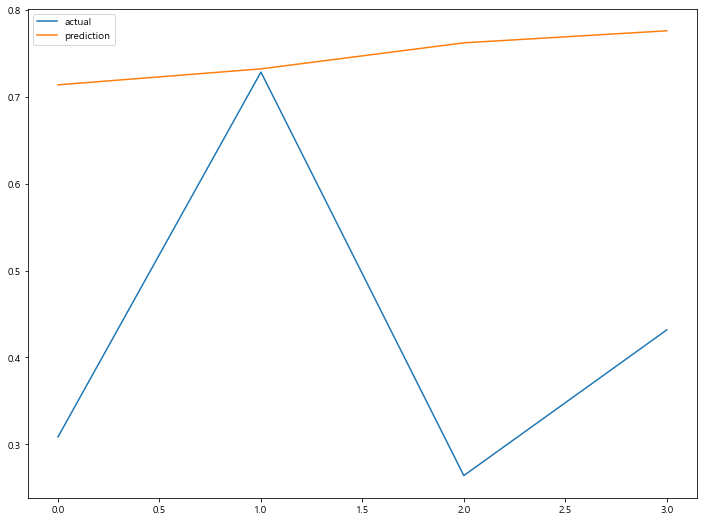

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

# 일별

In [15]:
data.columns

Index(['price', '병아리(원/수)', 'oil_avg', '소_소비자가_int', '돼지_소비자가_int', '미국기준금리'], dtype='object')

In [17]:
from sklearn.preprocessing import MinMaxScaler

data.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['price', '병아리(원/수)', 'oil_avg', '소_소비자가_int', '돼지_소비자가_int', '미국기준금리']
data_scaled = scaler.fit_transform(data[scale_cols])
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = scale_cols

In [18]:
data_scaled.head()
data_scaled.shape

(2996, 6)

In [19]:
TEST_SIZE = 600
WINDOW_SIZE = 20

train = data_scaled[:-TEST_SIZE]
test = data_scaled[-TEST_SIZE:]

In [20]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [21]:
from sklearn.model_selection import train_test_split

feature_cols = ['병아리(원/수)', 'oil_avg', '소_소비자가_int', '돼지_소비자가_int', '미국기준금리']
label_cols = ['price']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size= .80)
x_train.shape, x_valid.shape

((475, 20, 5), (1901, 20, 5))

In [22]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((600, 5), (600, 1))

In [23]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((580, 20, 5), (580, 1))

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [25]:
import os

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
21/30 [====================>.........] - ETA: 0s - loss: 0.3275 - accuracy: 0.0030    
Epoch 1: val_loss improved from inf to 0.10088, saving model to model\tmp_checkpoint.h5
30/30 [==============================] - 2s 21ms/step - loss: 0.2727 - accuracy: 0.0021 - val_loss: 0.1009 - val_accuracy: 0.0026
Epoch 2/200
24/30 [=======================>......] - ETA: 0s - loss: 0.0833 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 0.10088 to 0.05323, saving model to model\tmp_checkpoint.h5
30/30 [==============================] - 0s 12ms/step - loss: 0.0784 - accuracy: 0.0021 - val_loss: 0.0532 - val_accuracy: 0.0026
Epoch 3/200
28/30 [===========================>..] - ETA: 0s - loss: 0.0461 - accuracy: 0.0022    
Epoch 3: val_loss improved from 0.05323 to 0.03706, saving model to model\tmp_checkpoint.h5
30/30 [==============================] - 0s 16ms/step - loss: 0.0458 - accuracy: 0.0021 - val_loss: 0.0371 - val_accuracy: 0.0026
Epoch 4/200
20/30 [===================>..

In [27]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

19/19 [==============================] - 0s 2ms/step


(580, 1)

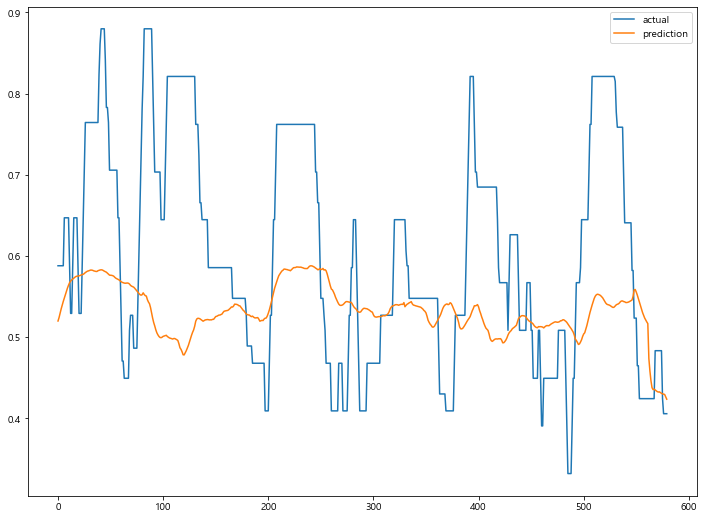

In [28]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

### 가진 데이터가 분포가 너무 넓어서, 일반 회귀 모델은 사용했을 때 정확도가 떨어짐. 분류회귀모델과 클러스터링 모델을 사용하는 것으로 변경함(random forest는 안고 가자)